# 02. Differential effects due to TFBS differences

in this notebook, i find motifs whose disruption is significantly associated w/ differential effects using linear models



In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

np.random.seed(2019)

QUANT_ALPHA = 0.05

## functions

In [3]:
def calculate_gc(row, col):
    cs = row[col].count("C")
    gs = row[col].count("G")
    gc = (cs+gs)/len(row[col])
    return gc

In [4]:
def calculate_cpg(row, col):
    cpgs = row[col].count("CG")
    cpg = cpgs/len(row[col])
    return cpg

In [5]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

## variables

In [6]:
motif_dir = "../../data/03_fimo/FIMO_results/"
motifs_f = "%s/hum_tf/fimo.txt" % motif_dir

In [7]:
motif_info_dir = "../../data/03_fimo/Kaia_FIMO/"
motif_map_f = "%s/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/motif_info.txt" % motif_info_dir

In [8]:
sig_motifs_f = "../../data/TF_Analysis/sig_motifs.txt"

In [9]:
index_f = "../../data/design/Hypertension__pooled.index.txt"

In [10]:
data_dir = "../../data/02_activs"

native_f = "%s/comp_results.CM.new_back.txt" % data_dir
native_f_vsmc = "%s/comp_results.VSMC.new_back.txt" % data_dir

In [11]:
mital_snps_f = "../../data/design/name_Mital_SNPS.txt"

## 1. import data

In [12]:
index = pd.read_table(index_f, sep="\t")
index.head()

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_1,RE_2,RE_3,REs_mutated,unique_name,snp,barcode,oligo,oligo_len,pool_num
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTGCTTGATAC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
1,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.2,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTCGGCGAACA,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
2,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.3,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CATGTTCGAGT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
3,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.4,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATCGTAAACTC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
4,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.5,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATAGGTTCGCT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1


In [13]:
index['dupe_info'] = index['tile_id'].str.split('.',expand=True)[0]

In [14]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,ZNF496,ZNF496,chr3:48020950:48021085__rs28637561__3:48021018...,32,61,+,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
1,ZNF496,ZNF496,chr3:48020950:48021085__rs28637561__3:48021018...,32,61,+,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
2,ZNF496,ZNF496,chr1:9440193:9440328__rs28742181__1:9440261:C:...,16,45,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
3,ZNF496,ZNF496,chr1:9440193:9440328__rs28742181__1:9440261:C:...,16,45,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
4,ZNF496,ZNF496,chr1:9440130:9440265__rs28669777__1:9440198:C:...,79,108,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT


In [15]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [16]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [17]:
sig_motifs = pd.read_table(sig_motifs_f)
sig_motifs = sig_motifs[sig_motifs["padj"] < 0.05]
print(len(sig_motifs))
sig_motifs.head()

90


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
0,M08571_1,10.449153,1.227057e-03,0.001075,0.121389,0.022938,M08571_1,DMBX1,activating,0.0,1.0
1,M05671_1,28.597301,8.910628e-08,0.002940,0.283033,0.000006,M05671_1,EOMES,activating,NaN,1.0
2,M05705_1,18.852119,1.412541e-05,0.001939,0.192104,0.000490,M05705_1,FIGLA,activating,0.0,1.0
3,M08661_1,14.341141,1.524955e-04,0.001476,0.149835,0.003341,M08661_1,FIGLA,activating,0.0,1.0
4,M05763_1,14.944286,1.107329e-04,0.001538,0.158258,0.002504,M05763_1,GLI2,activating,NaN,1.0


In [53]:
data = pd.read_table(native_f).reset_index()
data.head()

,index,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
0,4625__CONTROL_SNP_INDIV,443.728165,1.671327e-98,2.677466e-95,1.0,101.0,5.0,4.0,0.990103
1,4621__CONTROL_SNP_INDIV,18.523928,1.677846e-05,1.333196e-04,1.0,101.0,5.0,4.0,0.210511
2,4627__CONTROL_SNP_INDIV,72.258054,1.888185e-17,2.110376e-15,1.0,101.0,5.0,4.0,0.447188
3,4620__CONTROL_SNP_INDIV,42.557365,6.863931e-11,2.499095e-09,1.0,101.0,5.0,4.0,0.316654
4,4634__CONTROL_SNP_INDIV,51.275819,8.025819e-13,4.103413e-11,1.0,39.0,5.0,4.0,-1.395349


In [54]:
data.columns = ["index", "stat_comp", "pval_comp", "fdr_comp", "df.test_comp", "df.dna_comp", 
                  "df.rna.full_comp", "df.rna.red_comp", "logFC_comp"]
data.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp
165,951__WILDTYPE_SNP_INDIV,1.774174,1.828663e-01,2.976145e-01,1.0,13.0,5.0,4.0,0.356717
3191,3482__WILDTYPE_SNP_INDIV,0.580719,4.460305e-01,5.802984e-01,1.0,23.0,5.0,4.0,-0.138145
438,4369__WILDTYPE_SNP_INDIV,30.325520,3.652881e-08,6.804552e-07,1.0,26.0,5.0,4.0,0.570213
4251,4680__WILDTYPE_SNP_INDIV,1.053153,3.047820e-01,4.402712e-01,1.0,26.0,5.0,4.0,0.103843
2650,2697__WILDTYPE_SNP_INDIV,1.086781,2.971855e-01,4.321553e-01,1.0,26.0,5.0,4.0,0.098042


In [55]:
data['dupe_info'] = data['index'].str.split('_',expand=True)[0]

In [21]:
## mital snps 
mital_snps = pd.read_table(mital_snps_f, sep="\t")
mital_snps.head()

,name
0,chr1:2985619:2985754__rs886940486__1:2985687:C:T
1,chr1:2985628:2985763__1:2985696:G:C__1:2985696...
2,chr1:115259631:115259766__1:115259699:C:G__1:1...
3,chr1:156084367:156084502__1:156084435:A:G__1:1...
4,chr1:156084826:156084961__1:156084894:G:C__1:1...


In [22]:
index_no_mital = index[~index["name"].isin(mital_snps['name'])]

In [23]:
index_elem = index_no_mital[["element", "tile_type", "name",'unique_name', "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

## 2. filter to significant motifs only (found via model)

In [24]:
mapped_sig_motifs = motifs[motifs["# motif_id"].isin(sig_motifs["index"])]
print(len(mapped_sig_motifs))
len(motifs)

61338


1893432

In [25]:
uniq_motifs = list(mapped_sig_motifs["# motif_id"].unique())
print(len(uniq_motifs))

87


##### Do we want to try with al motifs, not only the ones explaining variance in MPRA activity?

In [77]:
best_motifs = motif_info[~pd.isnull(motif_info["Best Motif(s)? (Figure 2A)"])]
len(best_motifs)

1496

In [78]:
best_motifs["short_id"] = best_motifs["CIS-BP ID"].str.split(".", expand=True)[0]
#motifs["short_id"] = motifs["# motif_id"].str.split(".", expand=True)[0]
mapped_best_motifs = motifs[motifs["# motif_id"].isin(best_motifs["short_id"])]
len(mapped_best_motifs)

587735

In [28]:
uniq_motifs = list(mapped_best_motifs["# motif_id"].unique())
print(len(uniq_motifs))

1269


## 3. join motifs w/ element metadata

In [56]:
index_elem['sequence_name'] = index_elem['unique_name']+'_'+index['tile_type']
index_elem.sample(5)

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
109800,GATGTACAGATGGGTTTTTGGTGTGGATGTCCTTTCTGTTTGTGAG...,WILDTYPE_SNP_INDIV,chr5:77880264:77880399__rs10077261__5:77880332...,chr5:77880264:77880399__rs10077261__5:77880332...,chr5,+,77880264,77880399,2207,chr5:77880264:77880399__rs10077261__5:77880332...,chr5:77880264:77880399
131825,CTCAGCTCACTTCGACCTCTGCCTCCTGGGTTCAAGCGATTCTGCT...,WILDTYPE_SNP_INDIV,chr16:75426461:75426596__rs7499872__16:7542652...,chr16:75426461:75426596__rs7499872__16:7542652...,chr16,+,75426461,75426596,2648,chr16:75426461:75426596__rs7499872__16:7542652...,chr16:75426461:75426596
29150,GAGATCGTGCCATTGCATTCCAGCCTGGGCGACAAGGGCAAAATTC...,WILDTYPE_BUT_HAS_SNP,chr1:11836262:11836397__rs146803014__1:1183633...,chr1:11836262:11836397__rs146803014__1:1183633...,chr1,+,11836262,11836397,585,chr1:11836262:11836397__rs146803014__1:1183633...,chr1:11836262:11836397
215225,AAGAACAGTGCTGGGGGCAGTGTTGAAGATGACATCTGGAGAGGGC...,WILDTYPE_SNP_INDIV,chr3:41987852:41987987__rs1717027__3:41987920:T:C,chr3:41987852:41987987__rs1717027__3:41987920:...,chr3,+,41987852,41987987,4321,chr3:41987852:41987987__rs1717027__3:41987920:...,chr3:41987852:41987987
126650,GCTTCTCTTTAGCAAAAGAAATGTAATTTTAACAAAAATGTCATTG...,WILDTYPE_BUT_HAS_SNP,chr16:75344408:75344543__rs10514393__16:753444...,chr16:75344408:75344543__rs10514393__16:753444...,chr16,+,75344408,75344543,2545,chr16:75344408:75344543__rs10514393__16:753444...,chr16:75344408:75344543


In [57]:
motifs_merged = mapped_sig_motifs.merge(index_elem, left_on="sequence_name", right_on="sequence_name")
motifs_merged.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info,query
0,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,102,128,+,27.4242,4.800000e-10,0.000249,CTCTCCCCCTCCTCCCCCCCCTCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885,chr2:96769815:96769950
1,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,7,33,+,21.6566,3.320000e-08,0.003450,CCCCCTTCCTCCTCCTCCTCCTCTTCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885,chr2:96769815:96769950
2,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,105,131,+,21.1414,4.550000e-08,0.003500,TCCCCCTCCTCCCCCCCCTCTCCCCCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885,chr2:96769815:96769950
3,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,4,30,+,20.3030,7.450000e-08,0.003950,CTCCCCCCTTCCTCCTCCTCCTCCTCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885,chr2:96769815:96769950
4,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,91,117,+,19.2020,1.380000e-07,0.005310,TTCCCTTCCTCCTCTCCCCCTCCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885,chr2:96769815:96769950


In [58]:
ref_df = motifs_merged[motifs_merged["tile_type"].str.contains("BUT")]
alt_df = motifs_merged[motifs_merged["tile_type"].str.contains("INDIV")]
ref_df.sample(5)

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info,query
37901,M08661_1,FIGLA,chr17:45046300:45046435__rs76774446__17:450463...,55,63,+,11.3061,9.860000e-05,0.3190,GACACCTGC,ATGAGGTTGAAAAATGATTGTTCTAATGGGTCCTACCCTGAAAGCA...,WILDTYPE_BUT_HAS_SNP,chr17:45046300:45046435__rs76774446__17:450463...,chr17:45046300:45046435__rs76774446__17:450463...,chr17,+,45046300,45046435,488,chr17:45046300:45046435
52378,M00255_1,MITF,chr3:41805602:41805737__rs9854838__3:41805670:...,65,74,-,11.4771,3.530000e-05,0.7650,AATCACGTGT,CTTTGGTATACACAATAAACTGAGAAAATGAAAAAGTGTATAAATT...,WILDTYPE_BUT_HAS_SNP,chr3:41805602:41805737__rs9854838__3:41805670:C:A,chr3:41805602:41805737__rs9854838__3:41805670:...,chr3,+,41805602,41805737,3764,chr3:41805602:41805737
44901,M09070_1,ARX,chr3:41945544:41945679__rs77778906__3:41945612...,123,130,+,12.4040,6.510000e-05,0.1780,GTAATCCC,CTATTTTCTTTGTCCTCTTTTACATTTTACAAGTTTTTTACAATTA...,WILDTYPE_BUT_HAS_SNP,chr3:41945544:41945679__rs77778906__3:41945612...,chr3:41945544:41945679__rs77778906__3:41945612...,chr3,+,41945544,41945679,4213,chr3:41945544:41945679
55984,M09201_1,TBX15,chr5:32708034:32708169__rs58410343__5:32708102...,44,55,+,10.8878,7.710000e-05,0.3960,CTTGCCACCTTA,CCGTTGAATACTTTATAGAAAACTTGCCACCTTATTGTAGTAGCTT...,WILDTYPE_BUT_HAS_SNP,chr5:32708034:32708169__rs58410343__5:32708102...,chr5:32708034:32708169__rs58410343__5:32708102...,chr5,+,32708034,32708169,476,chr5:32708034:32708169
6838,M06446_1,TFAP2A,chr17:6473890:6474025__rs12946848__17:6473958:...,87,100,+,17.6633,9.770000e-07,0.0411,ACCCGCCTCGGCCT,ATGCCTGGCAAATTTTTGTATTTTTAGTAGAGACGGGGTTTCACCA...,WILDTYPE_BUT_HAS_SNP,chr17:6473890:6474025__rs12946848__17:6473958:G:A,chr17:6473890:6474025__rs12946848__17:6473958:...,chr17,+,6473890,6474025,3223,chr17:6473890:6474025


## 4. merge differential data w/ element data for model

In [59]:
index_elem = index_elem[index_elem["tile_type"].str.contains("WILDTYPE")]
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149


In [60]:
index_ref = index_elem[index_elem["tile_type"].str.contains("BUT")]
index_alt = index_elem[index_elem["tile_type"].str.contains("INDIV")]
index_ref.sample(5)

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
165675,AAATCAGTCCTTGATCCAATGGGCTGCAGAATGGATGTTGTATCAG...,WILDTYPE_BUT_HAS_SNP,chr4:120503823:120503958__rs12648182__4:120503...,chr4:120503823:120503958__rs12648182__4:120503...,chr4,+,120503823,120503958,3328,chr4:120503823:120503958__rs12648182__4:120503...,chr4:120503823:120503958
61575,GTGAACACATTATGCTGTTCGACAGAAAAACTCGATATGCAAGACA...,WILDTYPE_BUT_HAS_SNP,chr3:47946640:47946775__rs35199727__3:47946708...,chr3:47946640:47946775__rs35199727__3:47946708...,chr3,+,47946640,47946775,1236,chr3:47946640:47946775__rs35199727__3:47946708...,chr3:47946640:47946775
160650,AGACGGAGTCTCGCACTGTCACCCAGGCTAGAGTGCAGTGGTGTGA...,WILDTYPE_BUT_HAS_SNP,chr1:89153787:89153922__rs35492837__1:89153855...,chr1:89153787:89153922__rs35492837__1:89153855...,chr1,+,89153787,89153922,3227,chr1:89153787:89153922__rs35492837__1:89153855...,chr1:89153787:89153922
155150,CCCTCTGTTGAGTCAATTCTGGCCCACTTAGAAAACAACAACAACA...,WILDTYPE_BUT_HAS_SNP,chr2:65284555:65284690__rs2540948__2:65284623:T:C,chr2:65284555:65284690__rs2540948__2:65284623:...,chr2,+,65284555,65284690,3117,chr2:65284555:65284690__rs2540948__2:65284623:...,chr2:65284555:65284690
181950,GGACATTCCATATAGAAATGTGTCCAAAGTGTCATTTTTTTTTCTT...,WILDTYPE_BUT_HAS_SNP,chr2:216296189:216296324__rs1250242__2:2162962...,chr2:216296189:216296324__rs1250242__2:2162962...,chr2,+,216296189,216296324,3654,chr2:216296189:216296324__rs1250242__2:2162962...,chr2:216296189:216296324


In [61]:
data = data[data["index"].str.contains("WILDTYPE")]
data.head()

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info
21,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460
22,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163
23,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115
24,2812__WILDTYPE_SNP_INDIV,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812
25,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079


In [62]:
print(len(data))
data_elem = data.merge(index_ref[["element", "dupe_info"]], left_on=["dupe_info"],
                       right_on=["dupe_info"])
data_elem = data_elem.merge(index_alt[["element", "dupe_info"]], left_on=["dupe_info"],
                            right_on=["dupe_info"], suffixes=("_ref", "_alt"))
print(len(data))
data_elem.head()

4661
4661


,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,element_alt
0,2460__WILDTYPE_SNP_INDIV,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...
1,1163__WILDTYPE_SNP_INDIV,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...
2,1115__WILDTYPE_SNP_INDIV,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...
3,2812__WILDTYPE_SNP_INDIV,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...
4,1079__WILDTYPE_SNP_INDIV,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...


In [63]:
data_elem["gc_ref"] = data_elem.apply(calculate_gc, col="element_ref", axis=1)
data_elem["gc_alt"] = data_elem.apply(calculate_gc, col="element_alt", axis=1)
data_elem["cpg_ref"] = data_elem.apply(calculate_cpg, col="element_ref", axis=1)
data_elem["cpg_alt"] = data_elem.apply(calculate_cpg, col="element_alt", axis=1)
data_elem.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,element_alt,gc_ref,gc_alt,cpg_ref,cpg_alt
327,349__WILDTYPE_SNP_INDIV,4.703612,3.009931e-02,7.171902e-02,1.0,26.0,5.0,4.0,-0.314436,349,AAGGGTTAATATCTTCAGCATCTCATACATCAATAAGAGAAAGGAA...,AAGGGTTAATATCTTCAGCATCTCATACATCAATAAGAGAAAGGAA...,0.414815,0.422222,0.007407,0.014815
137,1172__WILDTYPE_SNP_INDIV,58.133007,2.449812e-14,1.757283e-12,1.0,26.0,5.0,4.0,0.630635,1172,AAAGTTCCACTCTAGCTGGGCATGGTGGCTCACGCCTGTAATCCCA...,AAAGTTCCACTCTAGCTGGGCATGGTGGCTCACGCCTGTAATCCCA...,0.518519,0.525926,0.029630,0.029630
3037,2377__WILDTYPE_SNP_INDIV,0.961728,3.267519e-01,4.631790e-01,1.0,26.0,5.0,4.0,-0.115241,2377,GGTACTGCACGGAGAGGGCAGGGGGTGGCGTGAAGCTTGCAGGCAC...,GGTACTGCACGGAGAGGGCAGGGGGTGGCGTGAAGCTTGCAGGCAC...,0.674074,0.666667,0.044444,0.037037
4402,4018__WILDTYPE_SNP_INDIV,7.012341,8.094979e-03,2.457642e-02,1.0,25.0,5.0,4.0,-0.308253,4018,TTGGCTATATGGGCTCTCTGTGGTTCCATATGAAATTTAAAGTAGT...,TTGGCTATATGGGCTCTCTGTGGTTCCATATGAAATTTAAAGTAGT...,0.340741,0.340741,0.000000,0.000000
1886,922__WILDTYPE_SNP_INDIV,0.417906,5.179835e-01,6.455988e-01,1.0,26.0,5.0,4.0,-0.057656,922,CCTCTACCTCCCAGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCGA...,CCTCTACCTCCCAGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCGA...,0.548148,0.540741,0.022222,0.014815


In [64]:
data_elem["delta_gc"] = data_elem["gc_ref"] - data_elem["gc_alt"] 
data_elem["delta_cpg"] = data_elem["cpg_ref"] - data_elem["cpg_alt"]
data_elem["mean_gc"] = data_elem[["gc_ref", "gc_alt"]].mean(axis=1)
data_elem["mean_cpg"] = data_elem[["cpg_ref", "cpg_alt"]].mean(axis=1)
data_elem["abs_delta_gc"] = np.abs(data_elem["delta_gc"])
data_elem["abs_delta_cpg"] = np.abs(data_elem["delta_cpg"])
data_elem.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,...,gc_ref,gc_alt,cpg_ref,cpg_alt,delta_gc,delta_cpg,mean_gc,mean_cpg,abs_delta_gc,abs_delta_cpg
3980,841__WILDTYPE_SNP_INDIV,1.476592,0.224308,0.348312,1.0,26.0,5.0,4.0,0.065120,841,...,0.540741,0.533333,0.000000,0.000000,0.007407,0.000000,0.537037,0.000000,0.007407,0.000000
2136,3959__WILDTYPE_SNP_INDIV,3.492985,0.061629,0.127284,1.0,26.0,5.0,4.0,0.182885,3959,...,0.525926,0.518519,0.037037,0.029630,0.007407,0.007407,0.522222,0.033333,0.007407,0.007407
589,4527__WILDTYPE_SNP_INDIV,19.622372,0.000009,0.000082,1.0,26.0,5.0,4.0,0.500177,4527,...,0.496296,0.503704,0.007407,0.007407,-0.007407,0.000000,0.500000,0.007407,0.007407,0.000000
699,3633__WILDTYPE_SNP_INDIV,0.289097,0.590800,0.708783,1.0,7.0,5.0,4.0,-0.423313,3633,...,0.355556,0.348148,0.007407,0.007407,0.007407,0.000000,0.351852,0.007407,0.007407,0.000000
2493,528__WILDTYPE_SNP_INDIV,21.994775,0.000003,0.000028,1.0,24.0,5.0,4.0,-0.560795,528,...,0.325926,0.333333,0.007407,0.007407,-0.007407,0.000000,0.329630,0.007407,0.007407,0.000000


In [66]:
data_elem["abs_logFC_comp"] = np.abs(data_elem["logFC_comp"])
data_elem["box_abs_logFC_comp"] = boxcox(data_elem["abs_logFC_comp"])[0]

In [40]:
def uniq_motif(row):
    if row.ref_motif == True:
        if row.alt_motif == True:
            return "maintained"
        else:
            return "disrupted in ALT"
    else:
        if row.alt_motif == True:
            return "disrupted in REF"
        else:
            return "not present"

In [52]:
data_filt = data_elem[((data_elem["CM_padj_ref"] < QUANT_ALPHA) | (data_elem["CM_padj_alt"] < QUANT_ALPHA))]
print(len(data_filt))

337


In [69]:
data_filt = data_elem[((data_elem["fdr_comp"] < 0.1))]
print(len(data_filt))

622


In [44]:
def motif_disrupted(row):
    if row["motif_sum"] == 1:
        return "c - disrupted"
    elif row["motif_sum"] == 0:
        return "b - not present"
    else:
        return "a - maintained"

0.0109676025450598
0.22285853928077326
0.09696969696969697


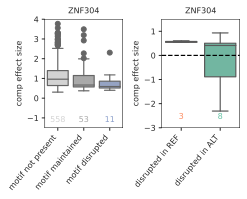

8.187441811671872e-06
0.11898391799162267
0.39285714285714285


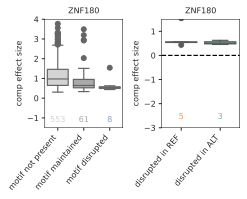

In [71]:
# plot some examples ZNF
examps = ["ZNF304","ZNF180"]
#,"ZNF30","ZNF444",'ZNF582',"ZNF529","ZNF219","ZNF85","ZNF740","ZNF90"
order1 = ["b - not present", "a - maintained", "c - disrupted"]
order2 = ["disrupted in REF", "disrupted in ALT"]
pal1 = {"b - not present": "lightgray", "a - maintained": "darkgray", "c - disrupted": sns.color_palette("Set2")[2]}
pal2 = {"disrupted in REF": sns.color_palette("Set2")[1], 
        "disrupted in ALT": sns.color_palette("Set2")[0]}

for symb in examps:
    motif_id = motif_map[motif_map["gene_name"] == symb]["index"].iloc[0]
    
    tmp = data_filt.copy()
    
    # determine whether motif is in human or mouse sequence
    ref_motifs_sub = ref_df[(ref_df["motif_alt_id"] == symb)]["element"].unique()
    alt_motifs_sub = alt_df[(alt_df["motif_alt_id"] == symb)]["element"].unique()
    tmp["ref_motif"] = tmp["element_ref"].isin(ref_motifs_sub)
    tmp["alt_motif"] = tmp["element_alt"].isin(alt_motifs_sub)
    
    tmp["motif_sum"] = tmp[["ref_motif", "alt_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)
    
    fig, axarr = plt.subplots(figsize=(3.5, 2), nrows=1, ncols=2)
    
    ax = axarr[0]
    sns.boxplot(data=tmp, x="motif_disrupted", y="abs_logFC_comp", order=order1, palette=pal1, 
                flierprops = dict(marker='o', markersize=5), ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["motif not present", "motif maintained", "motif disrupted"], rotation=50, 
                       ha="right", va="top")
    ax.set_ylabel("comp effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    
    for i, label in enumerate(order1):
        n = len(tmp[tmp["motif_disrupted"] == label])
        ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=pal1[label], size=fontsize)

    ax.set_ylim((-1.5, 4))
    
    # calc p-vals b/w dists
    dist1 = np.asarray(tmp[tmp["motif_disrupted"] == "b - not present"]["abs_logFC_comp"])
    dist2 = np.asarray(tmp[tmp["motif_disrupted"] == "a - maintained"]["abs_logFC_comp"])
    dist3 = np.asarray(tmp[tmp["motif_disrupted"] == "c - disrupted"]["abs_logFC_comp"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
    print(pval1)
    print(pval2)

    #annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
    #annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)


    ax = axarr[1]
    sns.boxplot(data=tmp, x="uniq_motif", y="logFC_comp", order=order2, palette=pal2,
                flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(order2, rotation=50, ha="right", va="top")
    mimic_r_boxplot(ax)
    ax.set_ylabel("comp effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)
    
    for i, label in enumerate(order2):
        n = len(tmp[tmp["uniq_motif"] == label])
        ax.annotate(str(n), xy=(i, -2.7), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal2[label], size=fontsize)
        
    # calc p-vals b/w dists
    #dist1 = np.asarray(tmp[tmp["uniq_motif"] == "maintained"]["logFC_comp"])
    dist2 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in REF"]["logFC_comp"])
    dist3 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in ALT"]["logFC_comp"])

    #dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    #u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist2, dist3, alternative="greater", use_continuity=False)
    print(pval2)
    #print(pval2)

    #annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
    #annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)

    ax.set_ylim((-3, 1.5))
    
    plt.subplots_adjust(wspace=0.5)
    if symb in ["ZNF304","ZNF219","ZNF90","ZNF180"]:
        fig.savefig(symb+"_VSMC.2.svg", dpi="figure", bbox_inches="tight")
    plt.show()

1.8666375452723277e-15
0.1856566833549847
0.5714285714285714


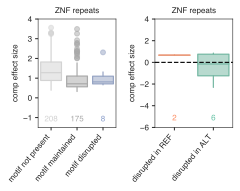

In [42]:
# plot some examples ZNF
examps = ["ZNF30",'ZNF582',"ZNF85","ZNF90","ZNF18","ZNF506","ZNF586","ZNF222"]
#examps = ["ZNF30","ZNF304","ZNF180",'ZNF582',"ZNF529","ZNF85"]

order1 = ["b - not present", "a - maintained", "c - disrupted"]
order2 = ["disrupted in REF", "disrupted in ALT"]
pal1 = {"b - not present": "lightgray", "a - maintained": "darkgray", "c - disrupted": sns.color_palette("Set2")[2]}
pal2 = {"disrupted in REF": sns.color_palette("Set2")[1], 
        "disrupted in ALT": sns.color_palette("Set2")[0]}

#for symb in examps:
    #motif_id = motif_map[motif_map["gene_name"] == symb]["index"].iloc[0]
    
tmp = data_filt.copy()

# determine whether motif is in human or mouse sequence
ref_motifs_sub = ref_df[(ref_df["motif_alt_id"].isin(examps))]["element"].unique()
alt_motifs_sub = alt_df[(alt_df["motif_alt_id"].isin(examps))]["element"].unique()
tmp["ref_motif"] = tmp["element_ref"].isin(ref_motifs_sub)
tmp["alt_motif"] = tmp["element_alt"].isin(alt_motifs_sub)

tmp["motif_sum"] = tmp[["ref_motif", "alt_motif"]].sum(axis=1)
#tmp = tmp[tmp["motif_sum"] >= 1]
tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)

fig, axarr = plt.subplots(figsize=(3.5, 2), nrows=1, ncols=2)

ax = axarr[0]
sns.boxplot(data=tmp, x="motif_disrupted", y="abs_logFC_comp", order=order1, palette=pal1, 
            flierprops = dict(marker='o', markersize=5), ax=ax)
mimic_r_boxplot(ax)
ax.set_xticklabels(["motif not present", "motif maintained", "motif disrupted"], rotation=50, 
                   ha="right", va="top")
ax.set_ylabel("comp effect size")
ax.set_title("ZNF repeats")
ax.set_xlabel("")

for i, label in enumerate(order1):
    n = len(tmp[tmp["motif_disrupted"] == label])
    ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=pal1[label], size=fontsize)

ax.set_ylim((-1.5, 4))

# calc p-vals b/w dists
dist1 = np.asarray(tmp[tmp["motif_disrupted"] == "b - not present"]["abs_logFC_comp"])
dist2 = np.asarray(tmp[tmp["motif_disrupted"] == "a - maintained"]["abs_logFC_comp"])
dist3 = np.asarray(tmp[tmp["motif_disrupted"] == "c - disrupted"]["abs_logFC_comp"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
u, pval2 = stats.mannwhitneyu(dist2, dist3, alternative="two-sided", use_continuity=False)
print(pval1)
print(pval2)

#annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
#annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)


ax = axarr[1]
sns.boxplot(data=tmp, x="uniq_motif", y="logFC_comp", order=order2, palette=pal2,
            flierprops = dict(marker='o', markersize=5), ax=ax)
ax.set_xticklabels(order2, rotation=50, ha="right", va="top")
mimic_r_boxplot(ax)
ax.set_ylabel("comp effect size")
ax.set_title("ZNF repeats")
ax.set_xlabel("")
ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)

for i, label in enumerate(order2):
    n = len(tmp[tmp["uniq_motif"] == label])
    ax.annotate(str(n), xy=(i, -5.5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=pal2[label], size=fontsize)

# calc p-vals b/w dists
#dist1 = np.asarray(tmp[tmp["uniq_motif"] == "maintained"]["logFC_comp"])
dist2 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in REF"]["logFC_comp"])
dist3 = np.asarray(tmp[tmp["uniq_motif"] == "disrupted in ALT"]["logFC_comp"])

#dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]
dist3 = dist3[~np.isnan(dist3)]

#u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
u, pval2 = stats.mannwhitneyu(dist2, dist3, alternative="greater", use_continuity=False)
print(pval2)
#print(pval2)

#annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
#annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)

ax.set_ylim((-6, 4))

plt.subplots_adjust(wspace=0.5)
#if symb == "RARA":
    #fig.savefig("Fig3C.svg", dpi="figure", bbox_inches="tight")
plt.show()
fig.savefig("FigZNF_enriched_repeats_VSMC.svg", dpi="figure", bbox_inches="tight")

## 8. for every sequence pair, calculate the # identical motifs, the # motifs that fully turn over, and the # motifs that partially turn over

defined as:

- identical motifs = identical sequence in both species
- full turnover = motifs that are only present in one species
- partial turnover = motifs that are in both species but don't map to the exact same sequence

In [93]:
data_elem.head()

,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,...,mean_gc,mean_cpg,abs_delta_gc,abs_delta_cpg,abs_logFC_comp,box_abs_logFC_comp,index_ref,CM_padj_ref,index_alt,CM_padj_alt
0,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,...,0.459259,0.007407,0.000000,0.0,0.004084,-0.118034,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,0.884949,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,0.884949
1,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,...,0.522222,0.037037,0.007407,0.0,0.130726,-0.118034,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,0.148658,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,0.266019
2,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,...,0.329630,0.000000,0.007407,0.0,0.199032,-0.118034,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,0.884949,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,0.884949
3,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,...,0.314815,0.000000,0.007407,0.0,0.068022,-0.118034,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,0.999969,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,0.884949
4,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,...,0.248148,0.007407,0.007407,0.0,0.753282,-0.107329,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,0.997252,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,0.008783


In [94]:
turnover_results = {}

for i, row in data_elem.iterrows():
    if i % 100 == 0:
        print("...# %s..." % (i+1))

    ref_id = row["element_ref"]
    alt_id = row["element_alt"]
    
    ref_motifs_sub = motifs_merged[(motifs_merged['element'] == ref_id)]
    #print(ref_motifs_sub)
    alt_motifs_sub = motifs_merged[(motifs_merged['element'] == alt_id)]
    #print(alt_motifs_sub)
    #motifs_merged['# motif_id']
    
    # find total number of unique motifs (in both species)
    ref_motif_ids = list(ref_motifs_sub["# motif_id"].unique())
    #print(ref_motif_ids)
    alt_motif_ids = list(alt_motifs_sub["# motif_id"].unique())
    #print(alt_motif_ids)
    total_uniq_motifs = len(set(ref_motif_ids + alt_motif_ids))
    
    # find difference in motifs b/w the two species
    delta_motifs = len(ref_motif_ids) - len(alt_motif_ids)
    
    # find number of motifs that are in both species
    merge_sub = ref_motifs_sub[["# motif_id", 
                                  "matched_sequence"]].merge(alt_motifs_sub[["# motif_id", 
                                                                               "matched_sequence"]],
                                                             on="# motif_id",
                                                             suffixes=(" ref", " alt"))
    merge_sub = merge_sub.drop_duplicates()
    
    # find number of motifs that are *exactly the same* in both species
    merge_sub["identical"] = merge_sub["matched_sequence ref"] == merge_sub["matched_sequence alt"]
    
    # since there can be more than one occurrence of the same motif: 
    # if there is at least 1 instance of an identical motif, call it identical
    # otherwise, call it partial
    # to do this, sort the df and keep the first occurrence (which will always = True if it's there)
    merge_sub = merge_sub.sort_values(by=["# motif_id", 
                                          "identical"], ascending=False)[["# motif_id", "identical"]]
    merge_sub = merge_sub.drop_duplicates(subset="# motif_id")
    total_in_both = len(merge_sub)
    
    n_identical = len(merge_sub[merge_sub["identical"]])
    
    # find number that are partially different
    n_partial = len(merge_sub[~merge_sub["identical"]])
    
    # find number of motifs that fully turn over between species (i.e. are in only one species)
    n_ref_uniq = len(set(ref_motif_ids).difference(set(alt_motif_ids)))
    n_alt_uniq = len(set(alt_motif_ids).difference(set(ref_motif_ids)))
    n_turnover = n_ref_uniq + n_alt_uniq
    
    turnover_results["%s__%s" % (ref_id, alt_id)] = {"total_motifs": total_uniq_motifs,
                                                                       "total_shared_motifs": total_in_both,
                                                                       "n_identical_motifs": n_identical,
                                                                       "n_partial_motifs": n_partial,
                                                                       "n_turnover_motifs": n_turnover,
                                                                       "delta_motifs": delta_motifs,
                                                                       "motifs ref": set(ref_motif_ids).difference(set(alt_motif_ids)),
                                                                       "motifs alt": set(alt_motif_ids).difference(set(ref_motif_ids))}

...# 1...
...# 101...
...# 201...
...# 301...
...# 401...
...# 501...
...# 601...
...# 701...
...# 801...
...# 901...
...# 1001...
...# 1101...
...# 1201...
...# 1301...
...# 1401...
...# 1501...
...# 1601...
...# 1701...
...# 1801...
...# 1901...
...# 2001...
...# 2101...
...# 2201...
...# 2301...
...# 2401...
...# 2501...
...# 2601...
...# 2701...
...# 2801...
...# 2901...
...# 3001...
...# 3101...
...# 3201...
...# 3301...
...# 3401...
...# 3501...
...# 3601...
...# 3701...
...# 3801...
...# 3901...
...# 4001...
...# 4101...
...# 4201...
...# 4301...
...# 4401...
...# 4501...


In [95]:
turnover_df = pd.DataFrame.from_dict(turnover_results, orient="index").reset_index()

# split index column to separate id columns
turnover_df["element_ref"] = turnover_df["index"].str.split("__", expand=True)[0]
turnover_df["element_alt"] = turnover_df["index"].str.split("__", expand=True)[1]

# calculate percentages
turnover_df["perc_shared_motifs"] = (turnover_df["total_shared_motifs"]/turnover_df["total_motifs"])*100
turnover_df["perc_identical_motifs"] = (turnover_df["n_identical_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_partial_motifs"] = (turnover_df["n_partial_motifs"]/turnover_df["total_shared_motifs"])*100
turnover_df["perc_turnover_motifs"] = (turnover_df["n_turnover_motifs"]/turnover_df["total_motifs"])*100
turnover_df["abs_delta_motifs"] = np.abs(turnover_df["delta_motifs"])

turnover_df.head()

,index,total_motifs,total_shared_motifs,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,motifs ref,motifs alt,element_ref,element_alt,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,5,5,5,0,0,0,{},{},AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,100.0,100.0,0.0,0.0,0
1,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,15,15,15,0,0,0,{},{},AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,100.0,100.0,0.0,0.0,0
2,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,1,1,1,0,0,0,{},{},AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,100.0,100.0,0.0,0.0,0
3,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,0,0,0,0,0,0,{},{},AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,NaN,NaN,NaN,NaN,0
4,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,0,0,0,0,0,0,{},{},AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,NaN,NaN,NaN,NaN,0


In [10]:
#### save this results for downstream analysis #####
turnover_df.to_csv('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/analysis/02_TF_analysis/turnover_results_tf_diff.txt',
                  sep='\t', index=False)

NameError: name 'turnover_df' is not defined

## 9. merge motif turnover data w/ cis effects

In [11]:
turnover_df = pd.read_csv('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/analysis/02_TF_analysis/turnover_results_tf_diff.txt', sep='\t')

In [96]:
data_motifs = data_elem.merge(turnover_df, on=["element_ref", "element_alt"], how="left")
print(len(data_motifs))
data_motifs.head()

4593


,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,...,n_partial_motifs,n_turnover_motifs,delta_motifs,motifs ref,motifs alt,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs
0,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,...,0,0,0,{},{},100.0,100.0,0.0,0.0,0
1,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,...,0,0,0,{},{},100.0,100.0,0.0,0.0,0
2,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,...,0,0,0,{},{},100.0,100.0,0.0,0.0,0
3,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,...,0,0,0,{},{},NaN,NaN,NaN,NaN,0
4,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,...,0,0,0,{},{},NaN,NaN,NaN,NaN,0


## 11. plot cis effects v motif turnover

In [97]:
order = ["no diff effect", "significant diff effect"]
palette = {"no diff effect": "gray", "significant diff effect": sns.color_palette("Set2")[2]}

In [98]:
df = data_motifs

In [99]:
def diff_or_not(row):
    if row.fdr_comp >= 0.05:
        return "no diff effect"
    elif row.fdr_comp < 0.05:
        return "significant diff effect"
    
df["cis_status_one"] = df.apply(diff_or_not, axis=1)
df.head()

,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,...,n_turnover_motifs,delta_motifs,motifs ref,motifs alt,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs,cis_status_one
0,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,...,0,0,{},{},100.0,100.0,0.0,0.0,0,no diff effect
1,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,...,0,0,{},{},100.0,100.0,0.0,0.0,0,no diff effect
2,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,...,0,0,{},{},100.0,100.0,0.0,0.0,0,no diff effect
3,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,...,0,0,{},{},NaN,NaN,NaN,NaN,0,no diff effect
4,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,...,0,0,{},{},NaN,NaN,NaN,NaN,0,significant diff effect


In [102]:
len(df[(df['cis_status_one'] == 'significant diff effect') & (df['total_motifs'] > 0)])

1325

In [103]:
len(df[(df['cis_status_one'] == 'significant diff effect') & (df['abs_delta_motifs'] > 0)])

431

In [104]:
len(df[(df['cis_status_one'] == 'significant diff effect')])

1788

0.008116538750536969


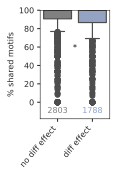

In [105]:
fig = plt.figure(figsize=(1.25, 2))
ax = sns.boxplot(data=df, x="cis_status_one", y="perc_shared_motifs", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["no diff effect", 'diff effect'], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% shared motifs")

for i, l in enumerate(order):
    n = len(df[df["cis_status_one"] == l])
    ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-18, 100))

# calc p-vals b/w dists
dist1 = np.asarray(df[df["cis_status_one"] == "no diff effect"]["perc_shared_motifs"])
dist2 = np.asarray(df[df["cis_status_one"] != "no diff effect"]["perc_shared_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="greater", use_continuity=False)
print(pval)

annotate_pval(ax, 0.2, 0.8, 55, 0, 55, pval, fontsize)

plt.show()
#fig.savefig("Fig3A_VSMC_active.svg", dpi="figure", bbox_inches="tight")
plt.close()

0.0


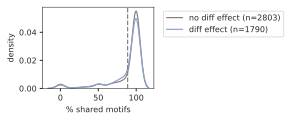

In [106]:
fig, ax = plt.subplots(figsize=(2, 1.5), nrows=1, ncols=1)
#filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
ctrls = np.abs(df[df["cis_status_one"] == "no diff effect"]["perc_shared_motifs"])

#sig_ctrls = data[(data["hg19_id"].str.contains("ctrl.")) & (data[sig_col].str.contains("significant"))][l2fc_col]
min_val = np.min(np.abs(ctrls))
print(min_val)
#min_vals.append(min_val)

sns.distplot(ctrls, hist=False, color="gray", label="no diff effect (n=%s)" % len(ctrls), ax=ax)

sub = np.abs(df[df["cis_status_one"] != "no diff effect"]["perc_shared_motifs"])

sns.distplot(sub, hist=False, color=sns.color_palette("Set2")[2], label="diff effect (n=%s)" % len(sub), ax=ax)

ax.set_xlabel("% shared motifs")
ax.set_ylabel("density")
#ax.axvline(x=np.quantile(sub, 0.25), linestyle="dashed", color=sns.color_palette("Set2")[2])
ax.axvline(x=np.mean(ctrls), linestyle="dashed", color="gray")
ax.axvline(x=np.median(sub), linestyle="dashed", color=sns.color_palette("Set2")[2])
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()
#fig.savefig("FigS7_%s.pdf" % c, dpi="figure", bbox_inches="tight")
plt.close()

In [107]:
### RepeatMasker ####
repeat_masker = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/snps_repeat_masker.info.txt', sep=' ')
repeat_masker['query'] = repeat_masker['query'].str.replace("_1", "")
repeat_masker = repeat_masker.drop_duplicates()
repeat_masker.head()

,query,family,beginR
0,chr10:102604446:102604581,L1PB1,LINE/L1
2,chr10:102615697:102615832,MSTB,LTR/ERVL-MaLR
4,chr10:102617651:102617786,(TTG)n,Simple_repeat
5,chr10:102617651:102617786,AluSx,SINE/Alu
8,chr10:104598927:104599062,MER11A,LTR/ERVK


In [108]:
cols = ['chrom', 'actual_start', 'actual_end']
index_elem['query'] = index_elem[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149


In [109]:
dupe_Repetitive = index_elem['dupe_info'][index_elem['query'].isin(repeat_masker['query'])].unique().tolist()
dupe_Repetitive[1:3]

['3', '6']

In [110]:
def get_repeat_status(row):
    if row.dupe_info in dupe_Repetitive:
        return "Repetitive"
    else:
        return "Not Repetitive"
    
df["Repeat_status_one"] = df.apply(get_repeat_status, axis=1)
df.Repeat_status_one.value_counts()

Repetitive        2479
Not Repetitive    2114
Name: Repeat_status_one, dtype: int64

In [111]:
np.mean(df[(df["cis_status_one"] != "no diff effect") & (df['Repeat_status_one']!='Repetitive')]['total_motifs'])

4.4180432020330365

2.4409023203909848e-11


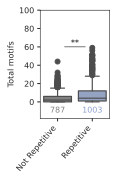

In [112]:
### repeat vs non-repeat
order = ["Not Repetitive", "Repetitive"]
palette = {"Not Repetitive": "gray", "Repetitive": sns.color_palette("Set2")[2]}

fig = plt.figure(figsize=(1.25, 2))
df_filt = df[df["cis_status_one"] != "no diff effect"]
ax = sns.boxplot(data=df_filt, x="Repeat_status_one", y="total_motifs", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["Not Repetitive", 'Repetitive'], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("Total motifs")

for i, l in enumerate(order):
    n = len(df_filt[df_filt["Repeat_status_one"] == l])
    ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-18, 100))

# calc p-vals b/w dists
dist1 = np.asarray(df_filt[df_filt["Repeat_status_one"] == "Not Repetitive"]["total_motifs"])
dist2 = np.asarray(df_filt[df_filt["Repeat_status_one"] != "Not Repetitive"]["total_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
print(pval)

#annotate_pval(ax, 0.2, 0.8, 55, 0, 55, pval, fontsize)
ax.plot([0.2, 0.2, 0.8, 0.8], [60, 60+0, 60+0, 60], c="black", lw=0.5)
if pval < 0.001:
    ax.text((0.2+0.8)*.5, 60, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval < 0.05:
    ax.text((0.2+0.8)*.5, 60, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+0.8)*.5, 60, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)

plt.show()
#fig.savefig("Fig3X_Repetitive_diff_CM.svg", dpi="figure", bbox_inches="tight")
plt.close()

0.26000606563894846


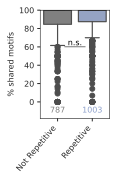

In [113]:
### repeat vs non-repeat
order = ["Not Repetitive", "Repetitive"]
palette = {"Not Repetitive": "gray", "Repetitive": sns.color_palette("Set2")[2]}

fig = plt.figure(figsize=(1.25, 2))
df_filt = df[df["cis_status_one"] != "no diff effect"]
#df_filt = df
ax = sns.boxplot(data=df_filt, x="Repeat_status_one", y="perc_shared_motifs", palette=palette, order=order,
                 flierprops = dict(marker='o', markersize=5))
mimic_r_boxplot(ax)

ax.set_xticklabels(["Not Repetitive", 'Repetitive'], rotation=50, ha='right', va='top')
ax.set_xlabel("")
ax.set_ylabel("% shared motifs")

for i, l in enumerate(order):
    n = len(df_filt[df_filt["Repeat_status_one"] == l])
    ax.annotate(str(n), xy=(i, -5), xycoords="data", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='top', 
                color=palette[l], size=fontsize)

ax.set_ylim((-18, 100))

# calc p-vals b/w dists
dist1 = np.asarray(df_filt[df_filt["Repeat_status_one"] == "Not Repetitive"]["perc_shared_motifs"])
dist2 = np.asarray(df_filt[df_filt["Repeat_status_one"] != "Not Repetitive"]["perc_shared_motifs"])

dist1 = dist1[~np.isnan(dist1)]
dist2 = dist2[~np.isnan(dist2)]

u, pval = stats.mannwhitneyu(dist1, dist2, alternative="less", use_continuity=False)
print(pval)

#annotate_pval(ax, 0.2, 0.8, 55, 0, 55, pval, fontsize)
ax.plot([0.2, 0.2, 0.8, 0.8], [60, 60+0, 60+0, 60], c="black", lw=0.5)
if pval < 0.001:
    ax.text((0.2+0.8)*.5, 60, '**', ha='center', va='bottom', color="black", size=fontsize)
elif pval < 0.05:
    ax.text((0.2+0.8)*.5, 60, '*', ha='center', va='bottom', color="black", size=fontsize)
else:
    ax.text((0.2+0.8)*.5, 60, 'n.s.', ha='center', va='bottom', color="black", size=fontsize)

plt.show()
#fig.savefig("Fig3X_Repetitive_diff_CM_shared.svg", dpi="figure", bbox_inches="tight")
plt.close()

0


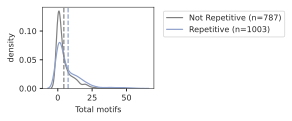

In [114]:
fig, ax = plt.subplots(figsize=(2, 1.5), nrows=1, ncols=1)
#filt = data[((data["HUES64_padj_hg19"] < QUANT_ALPHA) | (data["mESC_padj_mm9"] < QUANT_ALPHA))]
ctrls = np.abs(df_filt[df_filt["Repeat_status_one"] == "Not Repetitive"]["total_motifs"])

#sig_ctrls = data[(data["hg19_id"].str.contains("ctrl.")) & (data[sig_col].str.contains("significant"))][l2fc_col]
min_val = np.min(np.abs(ctrls))
print(min_val)
#min_vals.append(min_val)

sns.distplot(ctrls, hist=False, color="gray", label="Not Repetitive (n=%s)" % len(ctrls), ax=ax)

sub = np.abs(df_filt[df_filt["Repeat_status_one"] != "Not Repetitive"]["total_motifs"])

sns.distplot(sub, hist=False, color=sns.color_palette("Set2")[2], label="Repetitive (n=%s)" % len(sub), ax=ax)

ax.set_xlabel("Total motifs")
ax.set_ylabel("density")
#ax.axvline(x=np.quantile(sub, 0.25), linestyle="dashed", color=sns.color_palette("Set2")[2])
ax.axvline(x=np.mean(ctrls), linestyle="dashed", color="gray")
ax.axvline(x=np.mean(sub), linestyle="dashed", color=sns.color_palette("Set2")[2])
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.show()
#fig.savefig("FigSX_Repetitive_Diff_density.svg", dpi="figure", bbox_inches="tight")
plt.close()

## 12. which TF are enriched in differential activities

In [37]:
print(sig_motifs.shape)
sig_motifs.head()

(90, 11)


,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
0,M08571_1,10.449153,1.227057e-03,0.001075,0.121389,0.022938,M08571_1,DMBX1,activating,0.0,1.0
1,M05671_1,28.597301,8.910628e-08,0.002940,0.283033,0.000006,M05671_1,EOMES,activating,NaN,1.0
2,M05705_1,18.852119,1.412541e-05,0.001939,0.192104,0.000490,M05705_1,FIGLA,activating,0.0,1.0
3,M08661_1,14.341141,1.524955e-04,0.001476,0.149835,0.003341,M08661_1,FIGLA,activating,0.0,1.0
4,M05763_1,14.944286,1.107329e-04,0.001538,0.158258,0.002504,M05763_1,GLI2,activating,NaN,1.0


In [39]:
### RepeatMasker ####
repeat_masker = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/snps_repeat_masker.info.txt', sep=' ')
repeat_masker['query'] = repeat_masker['query'].str.replace("_1", "")
repeat_masker = repeat_masker.drop_duplicates()
repeat_masker.head()

,query,family,beginR
0,chr10:102604446:102604581,L1PB1,LINE/L1
2,chr10:102615697:102615832,MSTB,LTR/ERVL-MaLR
4,chr10:102617651:102617786,(TTG)n,Simple_repeat
5,chr10:102617651:102617786,AluSx,SINE/Alu
8,chr10:104598927:104599062,MER11A,LTR/ERVK


In [40]:
cols = ['chrom', 'actual_start', 'actual_end']
index_elem['query'] = index_elem[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149


In [67]:
biotype_motif_res = {}

for i, row in sig_motifs.iterrows():
    motif_id = row["index"]
    print("(#%s: %s)" % (i+1, motif_id))
    
    human_motifs_sub = motifs_merged[(motifs_merged["# motif_id"] == motif_id)]["unique_name"].unique()
    
    tmp = {}
    for biotype in ["Differential", "Repetitive"]:
        
        # group no CAGE + reclassified together here
        if biotype == "Repetitive":

            human_sub = index_elem[index_elem["query"].isin(repeat_masker['query'])]["unique_name"].unique()
            
            human_not_sub = index_elem[~index_elem["query"].isin(repeat_masker['query'])]["unique_name"].unique()
        else:
            human_sub = index_elem[index_elem["element"].isin(data_elem[data_elem['fdr_comp']<0.05]['element_ref']) | index_elem["element"].isin(data_elem[data_elem['fdr_comp']<0.05]['element_alt'])]["unique_name"].unique()
            
            human_not_sub = index_elem[~index_elem["unique_name"].isin(human_sub)]["unique_name"].unique()
    
        # count occurrences of biotypes w/ and w/o motifs
        n_human_biotype_w_motif = len([x for x in human_sub if x in human_motifs_sub])
        n_human_not_biotype_w_motif = len([x for x in human_not_sub if x in human_motifs_sub])

        n_human_biotype_wo_motif = len([x for x in human_sub if x not in human_motifs_sub])
        n_human_not_biotype_wo_motif = len([x for x in human_not_sub if x not in human_motifs_sub])

        # hypergeometric test - combined
        tot_biotype_w_motif = n_human_biotype_w_motif
        tot_biotype = n_human_biotype_w_motif + n_human_biotype_wo_motif
        tot_motif = tot_biotype_w_motif + n_human_not_biotype_w_motif
        tot = tot_biotype + n_human_not_biotype_w_motif + n_human_not_biotype_wo_motif

        both_pval = stats.hypergeom.sf(tot_biotype_w_motif-1, tot, tot_biotype, tot_motif)

        # note results

        s = biotype
        tmp["%s_pval" % s] = both_pval
        
    biotype_motif_res[motif_id] = tmp

(#1: M08571_1)
(#2: M05671_1)
(#3: M05705_1)
(#4: M08661_1)
(#5: M05763_1)
(#6: M08727_1)
(#7: M08729_1)
(#8: M05766_1)
(#9: M08731_1)
(#10: M08731_1)
(#11: M05767_1)
(#12: M06569_1)
(#13: M08749_1)
(#14: M02159_1)
(#15: M08863_1)
(#16: M08865_1)
(#17: M08876_1)
(#18: M08874_1)
(#19: M05868_1)
(#20: M08878_1)
(#21: M05897_1)
(#22: M05902_1)
(#23: M00255_1)
(#24: M08989_1)
(#25: M08991_1)
(#26: M09872_1)
(#27: M09070_1)
(#28: M09068_1)
(#29: M09072_1)
(#30: M05997_1)
(#31: M02715_1)
(#32: M10176_1)
(#33: M10181_1)
(#34: M09106_1)
(#35: M09106_1)
(#36: M06062_1)
(#37: M09141_1)
(#38: M09139_1)
(#39: M09145_1)
(#40: M09147_1)
(#41: M06128_1)
(#42: M06131_1)
(#43: M09185_1)
(#44: M09977_1)
(#45: M06148_1)
(#46: M06152_1)
(#47: M09197_1)
(#48: M02208_1)
(#49: M06156_1)
(#50: M09201_1)
(#51: M09205_1)
(#52: M06165_1)
(#53: M09209_1)
(#54: M06171_1)
(#55: M06172_1)
(#56: M06173_1)
(#57: M06174_1)
(#58: M09211_1)
(#59: M06175_1)
(#60: M06176_1)
(#61: M06186_1)
(#62: M06446_1)
(#63: M09241_1)
(

In [68]:
biotype_res = pd.DataFrame.from_dict(biotype_motif_res, orient="index").reset_index()
biotype_res.head()

,index,Differential_pval,Repetitive_pval
0,M08571_1,0.002266,1.766046e-53
1,M05671_1,0.474481,4.469542e-06
2,M05705_1,0.027286,1.010354e-05
3,M08661_1,0.018654,1.641933e-08
4,M05763_1,0.006416,1.091854e-10


In [69]:
biotype_melt = pd.melt(biotype_res, id_vars="index")
biotype_melt.head()

,index,variable,value
0,M08571_1,Differential_pval,0.002266
1,M05671_1,Differential_pval,0.474481
2,M05705_1,Differential_pval,0.027286
3,M08661_1,Differential_pval,0.018654
4,M05763_1,Differential_pval,0.006416


In [70]:
biotype_melt["padj"] = multicomp.multipletests(biotype_melt["value"], method="fdr_bh")[1]
len(biotype_melt[biotype_melt["padj"] < 0.05])

114

In [71]:
def is_sig(row):
    if row["padj"] < 0.05:
        return 1
    else:
        return 0

In [72]:
biotype_melt["sig"] = biotype_melt.apply(is_sig, axis=1)
biotype_melt.head()

,index,variable,value,padj,sig
0,M08571_1,Differential_pval,0.002266,0.005884,1
1,M05671_1,Differential_pval,0.474481,0.532643,0
2,M05705_1,Differential_pval,0.027286,0.042773,1
3,M08661_1,Differential_pval,0.018654,0.032458,1
4,M05763_1,Differential_pval,0.006416,0.013290,1


In [73]:
biotype_res = biotype_melt.pivot(index="index", columns="variable")["padj"]
biotype_res.head()

variable,Differential_pval,Repetitive_pval
index,,
M00255_1,0.042394,9.330860e-05
M02159_1,0.955953,9.559535e-01
M02208_1,0.112534,1.808775e-02
M02702_1,0.006648,6.426342e-08
M02715_1,0.060504,8.072782e-05


In [74]:
def mrna_vars(row):
    if row["Differential_pval"] < 0.05:
        return 0
    else:
        return np.nan
    
def Repetitive(row):
    if row["Repetitive_pval"] < 0.05:
        return 2
    else:
        return np.nan
    
    
biotype_res["Differential_enr"] = biotype_res.apply(mrna_vars, axis=1)
biotype_res["Repetitive_enr"] = biotype_res.apply(Repetitive, axis=1)
biotype_res = biotype_res.reset_index()

In [75]:
biotype_melt = pd.melt(biotype_res, id_vars="index", value_vars=["Differential_enr","Repetitive_enr"])
biotype_melt.head()

,index,variable,value
0,M00255_1,Differential_enr,0.0
1,M02159_1,Differential_enr,NaN
2,M02208_1,Differential_enr,NaN
3,M02702_1,Differential_enr,0.0
4,M02715_1,Differential_enr,NaN


In [76]:
biotype_melt = biotype_melt.merge(sig_motifs, on="index", how="left")
biotype_melt[biotype_melt['value']==0]

,index,variable,value,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
0,M00255_1,Differential_enr,0.0,53.591165,2.468670e-13,0.005503,0.524566,1.730538e-10,M00255_1,MITF,activating,NaN,1.0
3,M02702_1,Differential_enr,0.0,11.604161,6.580444e-04,0.001194,0.129545,1.263806e-02,M02702_1,ZFY,activating,0.0,1.0
8,M05705_1,Differential_enr,0.0,18.852119,1.412541e-05,0.001939,0.192104,4.897869e-04,M05705_1,FIGLA,activating,0.0,1.0
9,M05763_1,Differential_enr,0.0,14.944286,1.107329e-04,0.001538,0.158258,2.503992e-03,M05763_1,GLI2,activating,NaN,1.0
13,M05897_1,Differential_enr,0.0,29.732134,4.960570e-08,0.003057,0.294529,3.960296e-06,M05897_1,MEIS3,activating,0.0,1.0
15,M05997_1,Differential_enr,0.0,28.306649,1.035397e-07,0.002910,0.280319,6.598303e-06,M05997_1,PKNOX2,activating,0.0,1.0
17,M06128_1,Differential_enr,0.0,13.656894,2.194341e-04,0.001405,0.149188,4.661313e-03,M06128_1,SP1,activating,0.0,1.0
18,M06131_1,Differential_enr,0.0,15.482662,8.326553e-05,0.001593,0.166051,2.202609e-03,M06131_1,SP8,activating,0.0,1.0
20,M06152_1,Differential_enr,0.0,29.579477,5.367020e-08,0.003041,0.292993,3.960296e-06,M06152_1,TBX1,activating,NaN,1.0
21,M06156_1,Differential_enr,0.0,22.925923,1.683659e-06,0.002358,0.230651,7.507159e-05,M06156_1,TBX15,activating,NaN,NaN


## 12.1 Plot enrichment of TFBS in Active and Diff SNPs

In [129]:
biotype_melt.shape

(180, 13)

In [130]:
over_1p = biotype_melt[biotype_melt["rsq"] >= 0.001].sort_values(by="rsq", ascending=False)
len(over_1p)

166

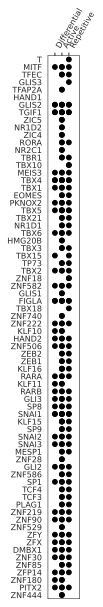

In [132]:
sub = over_1p.copy()
fig = plt.figure(figsize=(8, 10))

ax2 = plt.subplot2grid((1, 12), (0, 0), colspan=1)

yvals = []
symbs = []
c = 0
for i, row in sub.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

sub["yval"] = yvals
melt = pd.melt(sub, id_vars=["HGNC symbol", "yval"], value_vars=["value","Active_enr"])
ax2.plot(melt["value"], melt["HGNC symbol"], 'o', color="black")
ax2.set_xlim((-1, 3.5))
ax2.set_ylim((np.max(yvals)-0.5, -0.5))
ax2.tick_params(labelleft=True, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
ax2.xaxis.set_ticks([0,1,2])
ax2.set_xticklabels(["Differential","Active","Repetitive"], rotation=60, ha="left", va="bottom")

plt.show()
#fig.savefig("FigS10_activeDiff_enrichment.VSMC_repetitive.svg", dpi=300, bbox_inches="tight")
plt.close()

## 12.2 Enrichment of TF disrupted in differential tiles 

#### Read data

In [133]:
###motifs ref 
motifs_ref = pd.read_table('../../data/TF_Analysis/ref_motifs_filtered.txt', sep='\t')
motifs_ref.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,102,128,+,27.4242,4.800000e-10,0.000249,CTCTCCCCCTCCTCCCCCCCCTCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
1,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,7,33,+,21.6566,3.320000e-08,0.003450,CCCCCTTCCTCCTCCTCCTCCTCTTCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
2,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,105,131,+,21.1414,4.550000e-08,0.003500,TCCCCCTCCTCCCCCCCCTCTCCCCCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
3,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,4,30,+,20.3030,7.450000e-08,0.003950,CTCCCCCCTTCCTCCTCCTCCTCCTCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
4,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,91,117,+,19.2020,1.380000e-07,0.005310,TTCCCTTCCTCCTCTCCCCCTCCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885


In [134]:
###motifs alt
motifs_alt = pd.read_table('../../data/TF_Analysis/alt_motifs_filtered.txt.gz', sep='\t')
motifs_alt.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,102,128,+,27.4242,4.800000e-10,0.000249,CTCTCCCCCTCCTCCCCCCCCTCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
1,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,7,33,+,21.6566,3.320000e-08,0.003450,CCCCCTTCCTCCTCCTCCTCCTCTTCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
2,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,105,131,+,21.1414,4.550000e-08,0.003500,TCCCCCTCCTCCCCCCCCTCTCCCCCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
3,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,4,30,+,20.3030,7.450000e-08,0.003950,CTCCCCCCTTCCTCCTCCTCCTCCTCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
4,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,91,117,+,19.2020,1.380000e-07,0.005310,TTCCCTTCCTCCTCTCCCCCTCCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_SNP_INDIV,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885


In [157]:
data.sample(5)

,index,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info
114,3973__WILDTYPE_SNP_INDIV,1.070114,0.300920,0.574314,1.0,26.0,5.0,4.0,0.323014,3973
4046,3073__WILDTYPE_SNP_INDIV,3.139104,0.076436,0.276162,1.0,26.0,5.0,4.0,-0.707414,3073
3281,832__WILDTYPE_SNP_INDIV,0.602622,0.437579,0.691909,1.0,8.0,5.0,4.0,1.131058,832
1635,4539__WILDTYPE_SNP_INDIV,1.494013,0.221595,0.494612,1.0,24.0,5.0,4.0,0.485679,4539
151,4178__WILDTYPE_SNP_INDIV,3.234530,0.072101,0.267398,1.0,25.0,5.0,4.0,0.718895,4178


In [158]:
print(len(data))
data_filt = data[~data['index'].str.contains('SAMP')]
len(data_filt)

4654


4654

In [159]:
index_elem["dupe_info"] = pd.to_numeric(index_elem["dupe_info"] , errors='coerce')
dupe_repetitive = index_elem['dupe_info'][index_elem['query'].isin(repeat_masker['query'])].unique().tolist()
len(dupe_repetitive)

2485

In [160]:
dupe_repetitive[1:3]

[3, 6]

In [177]:
biotype_motif_res_hyper = {}

for i, row in sig_motifs.iterrows():
    motif_id = row["index"]
    print("(#%s: %s)" % (i+1, motif_id))
    
    tmp_res = {}
    
    tmp = data_filt.copy()
    tmp["dupe_info"] = pd.to_numeric(tmp["dupe_info"] , errors='coerce')
    #tmp["fdr_comp"] = pd.to_numeric(tmp["fdr_comp"] , errors='coerce')
    
    # determine whether motif is in human or mouse sequence
    ref_motifs_sub = motifs_ref[(motifs_ref["# motif_id"] == motif_id)]["dupe_info"].unique().tolist()
    alt_motifs_sub = motifs_alt[(motifs_alt["# motif_id"] == motif_id)]["dupe_info"].unique().tolist()
    tmp["ref_motif"] = tmp["dupe_info"].isin(ref_motifs_sub)
    tmp["alt_motif"] = tmp["dupe_info"].isin(alt_motifs_sub)
    
    tmp["motif_sum"] = tmp[["ref_motif", "alt_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)
    
    for biotype in ["Differential", "Repetitive"]:
        if biotype == "Differential":
        # count occurrences of biotypes w/ and w/o motifs
            n_human_biotype_w_motif = len(tmp[(tmp['motif_disrupted'] == 'c - disrupted') & (tmp['fdr_comp'] < 0.05)])
            n_human_not_biotype_w_motif = len(tmp[(tmp['motif_disrupted'] == 'c - disrupted') & (tmp['fdr_comp'] > 0.05)])

            n_human_biotype_wo_motif = len(tmp[(tmp['motif_disrupted'] == 'a - maintained') & (tmp['fdr_comp'] < 0.05)])
            n_human_not_biotype_wo_motif = len(tmp[(tmp['motif_disrupted'] == 'a - maintained') & (tmp['fdr_comp'] > 0.05)])
        else:
            n_human_biotype_w_motif = len(tmp[(tmp['motif_disrupted'] == 'c - disrupted') & (tmp['dupe_info'].isin(dupe_repetitive)) & (tmp['fdr_comp'] < 0.05)])
            n_human_not_biotype_w_motif = len(tmp[(tmp['motif_disrupted'] == 'c - disrupted') & (~tmp['dupe_info'].isin(dupe_repetitive)) & (tmp['fdr_comp'] < 0.05)])

            n_human_biotype_wo_motif = len(tmp[(tmp['motif_disrupted'] == 'a - maintained') & (tmp['dupe_info'].isin(dupe_repetitive)) & (tmp['fdr_comp'] < 0.05)])
            n_human_not_biotype_wo_motif = len(tmp[(tmp['motif_disrupted'] == 'a - maintained') & (~tmp['dupe_info'].isin(dupe_repetitive)) & (tmp['fdr_comp'] < 0.05)])


        # hypergeometric test - combined
        tot_biotype_w_motif = n_human_biotype_w_motif
        tot_biotype = n_human_biotype_w_motif + n_human_biotype_wo_motif
        tot_motif = tot_biotype_w_motif + n_human_not_biotype_w_motif
        tot = tot_biotype + n_human_not_biotype_w_motif + n_human_not_biotype_wo_motif

        both_pval = stats.hypergeom.sf(tot_biotype_w_motif-1, tot, tot_biotype, tot_motif)
        
        #chisq test 
        from scipy.stats import chi2_contingency 
        # using Pearson’s chi-squared statistic
        # corrected for the Yates’ continuity
        observed = np.array([[n_human_biotype_w_motif+1, n_human_biotype_wo_motif+1], [n_human_not_biotype_w_motif+1, n_human_not_biotype_wo_motif+1]])
        chi_val, p_val, dof, expected =  chi2_contingency(observed)
        chi_val, p_val, dof, expected

        # note results

        
        tmp_res["%s_pval" % biotype] = both_pval
        tmp_res["%s_n_disr" % biotype] = n_human_biotype_w_motif
        tmp_res["%s_pval_chisq" % biotype] = p_val
        
    biotype_motif_res_hyper[motif_id] = tmp_res
    
  

(#1: M08571_1)
(#2: M05671_1)
(#3: M05705_1)
(#4: M08661_1)
(#5: M05763_1)
(#6: M08727_1)
(#7: M08729_1)
(#8: M05766_1)
(#9: M08731_1)
(#10: M08731_1)
(#11: M05767_1)
(#12: M06569_1)
(#13: M08749_1)
(#14: M02159_1)
(#15: M08863_1)
(#16: M08865_1)
(#17: M08876_1)
(#18: M08874_1)
(#19: M05868_1)
(#20: M08878_1)
(#21: M05897_1)
(#22: M05902_1)
(#23: M00255_1)
(#24: M08989_1)
(#25: M08991_1)
(#26: M09872_1)
(#27: M09070_1)
(#28: M09068_1)
(#29: M09072_1)
(#30: M05997_1)
(#31: M02715_1)
(#32: M10176_1)
(#33: M10181_1)
(#34: M09106_1)
(#35: M09106_1)
(#36: M06062_1)
(#37: M09141_1)
(#38: M09139_1)
(#39: M09145_1)
(#40: M09147_1)
(#41: M06128_1)
(#42: M06131_1)
(#43: M09185_1)
(#44: M09977_1)
(#45: M06148_1)
(#46: M06152_1)
(#47: M09197_1)
(#48: M02208_1)
(#49: M06156_1)
(#50: M09201_1)
(#51: M09205_1)
(#52: M06165_1)
(#53: M09209_1)
(#54: M06171_1)
(#55: M06172_1)
(#56: M06173_1)
(#57: M06174_1)
(#58: M09211_1)
(#59: M06175_1)
(#60: M06176_1)
(#61: M06186_1)
(#62: M06446_1)
(#63: M09241_1)
(

In [179]:
biotype_res = pd.DataFrame.from_dict(biotype_motif_res_hyper, orient="index").reset_index()
biotype_res.head()

,index,Differential_pval,Differential_n_disr,Differential_pval_chisq,Repetitive_pval,Repetitive_n_disr,Repetitive_pval_chisq
0,M08571_1,0.626959,4,1.000000,0.700551,4,1.000000
1,M05671_1,1.000000,0,0.449837,1.000000,0,0.784309
2,M05705_1,0.887197,1,1.000000,0.769231,1,1.000000
3,M08661_1,0.720292,3,1.000000,0.502024,3,1.000000
4,M05763_1,0.860641,3,0.827385,0.957364,2,0.382685


In [180]:
biotype_melt = pd.melt(biotype_res, id_vars=["index","Differential_n_disr","Repetitive_n_disr"])
biotype_melt.head()

,index,Differential_n_disr,Repetitive_n_disr,variable,value
0,M08571_1,4,4,Differential_pval,0.626959
1,M05671_1,0,0,Differential_pval,1.000000
2,M05705_1,1,1,Differential_pval,0.887197
3,M08661_1,3,3,Differential_pval,0.720292
4,M05763_1,3,2,Differential_pval,0.860641


In [181]:
biotype_res["Differential_padj"] = multicomp.multipletests(biotype_res["Differential_pval"], method="fdr_bh")[1]
biotype_res["Repetitive_padj"] = multicomp.multipletests(biotype_res["Repetitive_pval"], method="fdr_bh")[1]
biotype_melt["padj"] = multicomp.multipletests(biotype_melt["value"], method="fdr_bh")[1]
biotype_melt.head()

,index,Differential_n_disr,Repetitive_n_disr,variable,value,padj
0,M08571_1,4,4,Differential_pval,0.626959,1.0
1,M05671_1,0,0,Differential_pval,1.000000,1.0
2,M05705_1,1,1,Differential_pval,0.887197,1.0
3,M08661_1,3,3,Differential_pval,0.720292,1.0
4,M05763_1,3,2,Differential_pval,0.860641,1.0


In [167]:
def is_sig_dif(row):
    if row["Differential_pval"] < 0.05:
        return 1
    else:
        return 0

def is_sig_rep(row):
    if row["Repetitive_pval"] < 0.05:
        return 1
    else:
        return 0

In [168]:
biotype_res["Diff_sig"] = biotype_res.apply(is_sig_dif, axis=1)
biotype_res["rep_sig"] = biotype_res.apply(is_sig_rep, axis=1)
biotype_res.head()

,index,Differential_pval,Differential_n_disr,Repetitive_pval,Repetitive_n_disr,Differential_padj,Repetitive_padj,Diff_sig,rep_sig
0,M08571_1,0.626959,4,0.700551,4,1.0,1.0,0,0
1,M05671_1,1.000000,0,1.000000,0,1.0,1.0,0,0
2,M05705_1,0.887197,1,0.769231,1,1.0,1.0,0,0
3,M08661_1,0.720292,3,0.502024,3,1.0,1.0,0,0
4,M05763_1,0.860641,3,0.957364,2,1.0,1.0,0,0


In [169]:
plot = biotype_res[biotype_res["Differential_n_disr"] >= 20].sort_values(by="Differential_n_disr", ascending=False)

In [170]:
biotype_res = biotype_res.merge(sig_motifs, on="index", how="left")
biotype_res[biotype_res['Repetitive_pval']<0.05]

,index,Differential_pval,Differential_n_disr,Repetitive_pval,Repetitive_n_disr,Differential_padj,Repetitive_padj,Diff_sig,rep_sig,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
75,ZNF180,0.443231,7,0.01817,7,1.0,1.0,0,1,9.939986,0.001617,0.001023,0.119003,0.028701,ZNF180,ZNF180,activating,0.0,1.0


In [172]:
full_pal = {}
for i, row in biotype_res.iterrows():
    full_pal[row["HGNC symbol"]] = sns.color_palette("pastel")[0]

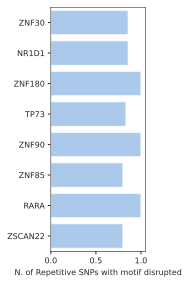

In [173]:
## plot results
fig = plt.figure(figsize=(3.5, 4.5))
tmp = biotype_res[biotype_res["Differential_n_disr"] >= 5].sort_values(by="Differential_n_disr", ascending=False)
tmp = tmp[tmp["Repetitive_n_disr"]/tmp["Differential_n_disr"] >= 0.8].sort_values(by="Differential_n_disr", ascending=False)
ax1 = plt.subplot2grid((1, 6), (0, 3), colspan=3)

yvals = []
symbs = []
c = 0
for i, row in tmp.iterrows():
    symb = row["HGNC symbol"]
    if symb not in symbs:
        yvals.append(c)
        symbs.append(symb)
        c += 1
    else:
        yvals.append(c)

tmp["yval"] = yvals
sns.barplot(y="HGNC symbol", x=tmp["Repetitive_n_disr"]/tmp["Differential_n_disr"], data=tmp, palette=full_pal, ax=ax1)
ax1.set_ylabel("")
ax1.set_xlabel("N. of Repetitive SNPs with motif disrupted")

plt.show()
#fig.savefig("Fig3D_CM_motifdisrup_top_diff_rep.svg", dpi="figure", bbox_inches="tight")
plt.close()

In [174]:
biotype_res.to_csv('../../data/TF_Analysis/motifs_disruptionrep_dif_analysis.VSMC.txt.gz', sep="\t", index=False, compression="gzip")

0.007436878055542802
0.01646315669143017
0.0036277906307815677
0.3614841650858615
0.0023752727176833653
0.015873015873015872


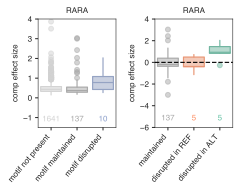

0.003678505212324366
0.11358045855940882
0.4823663592117219
0.34724974375169515
0.10838599203434385
0.13218931342502194


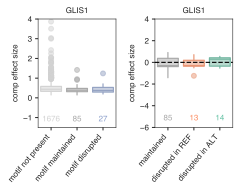

In [57]:
# plot some examples
examps = ["RARA","GLIS1"]
order1 = ["b - not present", "a - maintained", "c - disrupted"]
order2 = ["maintained", "disrupted in REF", "disrupted in ALT"]
pal1 = {"b - not present": "lightgray", "a - maintained": "darkgray", "c - disrupted": sns.color_palette("Set2")[2]}
pal2 = {"maintained": "darkgray", "disrupted in REF": sns.color_palette("Set2")[1], 
        "disrupted in ALT": sns.color_palette("Set2")[0]}

for symb in examps:
    motif_id = sig_motifs[sig_motifs['HGNC symbol'] == symb]['index'].iloc[0]
    
    tmp = data_elem.copy()
    #tmp['abs_logFC_comp'] = np.absolute(tmp["logFC_comp"])
    #tmp = tmp[tmp['dupe_info'].isin(dupe_repetitive)]
    
    # determine whether motif is in human or mouse sequence
    ref_motifs_sub = ref_df[(ref_df["# motif_id"] == motif_id)]["element"].unique()
    alt_motifs_sub = alt_df[(alt_df["# motif_id"] == motif_id)]["element"].unique()
    tmp["ref_motif"] = tmp["element_ref"].isin(ref_motifs_sub)
    tmp["alt_motif"] = tmp["element_alt"].isin(alt_motifs_sub)
    
    tmp["motif_sum"] = tmp[["ref_motif", "alt_motif"]].sum(axis=1)
    #tmp = tmp[tmp["motif_sum"] >= 1]
    tmp["motif_disrupted"] = tmp.apply(motif_disrupted, axis=1)
    tmp["uniq_motif"] = tmp.apply(uniq_motif, axis=1)
    
    fig, axarr = plt.subplots(figsize=(3.5, 2), nrows=1, ncols=2)
    
    ax = axarr[0]
    tmp["dupe_info"] = tmp["dupe_info"].astype(int)
    #tmp_2 = tmp[(tmp['dupe_info'].isin(dupe_repetitive)) & (tmp['fdr_comp'] < 0.05)]
    tmp_2 = tmp[tmp['fdr_comp'] < 0.05]
    sns.boxplot(data=tmp_2, x="motif_disrupted", y="abs_logFC_comp", order=order1, palette=pal1, 
                flierprops = dict(marker='o', markersize=5), ax=ax)
    mimic_r_boxplot(ax)
    ax.set_xticklabels(["motif not present", "motif maintained", "motif disrupted"], rotation=50, 
                       ha="right", va="top")
    ax.set_ylabel("comp effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    
    for i, label in enumerate(order1):
        n = len(tmp_2[tmp_2["motif_disrupted"] == label])
        ax.annotate(str(n), xy=(i, -0.9), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='top', 
                    color=pal1[label], size=fontsize)

    ax.set_ylim((-1.5, 4))
    
    # calc p-vals b/w dists
    dist1 = np.asarray(tmp_2[tmp_2["motif_disrupted"] == "b - not present"]["abs_logFC_comp"])
    dist2 = np.asarray(tmp_2[tmp_2["motif_disrupted"] == "a - maintained"]["abs_logFC_comp"])
    dist3 = np.asarray(tmp_2[tmp_2["motif_disrupted"] == "c - disrupted"]["abs_logFC_comp"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="two-sided", use_continuity=False)
    u, pval3 = stats.mannwhitneyu(dist2, dist3, alternative="less", use_continuity=False)
    print(pval1)
    print(pval2)
    print(pval3)

    #annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
    #annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)


    ax = axarr[1]
    sns.boxplot(data=tmp_2, x="uniq_motif", y="logFC_comp", order=order2, palette=pal2,
                flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(order2, rotation=50, ha="right", va="top")
    mimic_r_boxplot(ax)
    ax.set_ylabel("comp effect size")
    ax.set_title(symb)
    ax.set_xlabel("")
    ax.axhline(y=0, linestyle="dashed", color="black", zorder=100)
    
    for i, label in enumerate(order2):
        n = len(tmp_2[tmp_2["uniq_motif"] == label])
        ax.annotate(str(n), xy=(i, -5.5), xycoords="data", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=pal2[label], size=fontsize)
        
    # calc p-vals b/w dists
    dist1 = np.asarray(tmp_2[tmp_2["uniq_motif"] == "maintained"]["logFC_comp"])
    dist2 = np.asarray(tmp_2[tmp_2["uniq_motif"] == "disrupted in REF"]["logFC_comp"])
    dist3 = np.asarray(tmp_2[tmp_2["uniq_motif"] == "disrupted in ALT"]["logFC_comp"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]
    dist3 = dist3[~np.isnan(dist3)]

    u, pval1 = stats.mannwhitneyu(dist1, dist2, alternative="greater", use_continuity=False)
    u, pval2 = stats.mannwhitneyu(dist1, dist3, alternative="less", use_continuity=False)
    u, pval3 = stats.mannwhitneyu(dist2, dist3, alternative="less", use_continuity=False)
    print(pval1)
    print(pval2)
    print(pval3)

    #annotate_pval(ax, 0.2, 0.8, 5.3, 0, 5.3, pval1, fontsize)
    #annotate_pval(ax, 0.2, 1.8, 6.8, 0, 6.8, pval2, fontsize)

    ax.set_ylim((-6, 4))
    
    plt.subplots_adjust(wspace=0.5)
    #if symb == "RARA":
        #fig.savefig("FigS4E_RARA_VSMC.svg", dpi="figure", bbox_inches="tight")
    plt.show()

## 13. write motif files

In [156]:
data_motifs.head()

,stat_comp,pval_comp,fdr_comp,df.test_comp,df.dna_comp,df.rna.full_comp,df.rna.red_comp,logFC_comp,dupe_info,element_ref,...,n_identical_motifs,n_partial_motifs,n_turnover_motifs,delta_motifs,perc_shared_motifs,perc_identical_motifs,perc_partial_motifs,perc_turnover_motifs,abs_delta_motifs,cis_status_one
0,0.002270,0.962001,0.975808,1.0,26.0,5.0,4.0,-0.004084,2460,AAAAAAAAAAAAAAAAAAAAAAAAAATTAGCCAGACATGTTGGCAG...,...,5,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
1,1.350091,0.245262,0.373644,1.0,26.0,5.0,4.0,-0.130726,1163,AAAAAAAAAAAAAAAAAAAAAAGGCTGGGCGTGGTGGCGGGCGCCT...,...,15,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
2,1.966163,0.160856,0.271683,1.0,26.0,5.0,4.0,-0.199032,1115,AAAAAAAAAAAAAAAAAAAGATACTTATTTTTGTCCTTTAAACAAG...,...,1,0,0,0,100.0,100.0,0.0,0.0,0,no diff effect
3,0.018015,0.893229,0.932034,1.0,9.0,5.0,4.0,-0.068022,2812,AAAAAAAAAAAAAAAAATGCAATAGATGTATATATACTGAAGGGGC...,...,0,0,0,0,NaN,NaN,NaN,NaN,0,no diff effect
4,8.169896,0.004259,0.014344,1.0,17.0,5.0,4.0,-0.753282,1079,AAAAAAAAAAAAAAGAAAAGAAAAGAAAATAGACTGTAAGAAATTG...,...,0,0,0,0,NaN,NaN,NaN,NaN,0,significant diff effect


In [159]:
ref_df = motifs_merged[(motifs_merged["tile_type"].str.contains("BUT")) | (motifs_merged["tile_type"] == "RANDOM")]
alt_df = motifs_merged[(motifs_merged["tile_type"].str.contains("INDIV")) | (motifs_merged["tile_type"] == "RANDOM")]

In [160]:
ref_df.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info
135,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,102,128,+,27.4242,4.800000e-10,0.000249,CTCTCCCCCTCCTCCCCCCCCTCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
136,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,7,33,+,21.6566,3.320000e-08,0.003450,CCCCCTTCCTCCTCCTCCTCCTCTTCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
137,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,105,131,+,21.1414,4.550000e-08,0.003500,TCCCCCTCCTCCCCCCCCTCTCCCCCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
138,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,4,30,+,20.3030,7.450000e-08,0.003950,CTCCCCCCTTCCTCCTCCTCCTCCTCT,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885
139,ZNF529,ZNF529,chr2:96769815:96769950__rs13009727__2:96769883...,91,117,+,19.2020,1.380000e-07,0.005310,TTCCCTTCCTCCTCTCCCCCTCCTCCC,CCTCTCCCCCCTTCCTCCTCCTCCTCCTCTTCCTCTTTTTCCTTCC...,WILDTYPE_BUT_HAS_SNP,chr2:96769815:96769950__rs13009727__2:96769883...,chr2:96769815:96769950__rs13009727__2:96769883...,chr2,+,96769815,96769950,2885


In [161]:
ref_f = "../../data/ref_motifs_filtered.txt.gz"
ref_df.to_csv(ref_f, sep="\t", index=False, compression="gzip")

In [162]:
alt_f = "../../data/alt_motifs_filtered.txt.gz"
alt_df.to_csv(alt_f, sep="\t", index=False, compression="gzip")

In [291]:
data_motifs.to_csv('../../data/motifs_disruption_analysis.VSMC.txt.gz', sep="\t", index=False, compression="gzip")

In [77]:
biotype_melt.to_csv('../../data/motifs_enrichment_analysis.CM.txt.gz', sep="\t", index=False, compression="gzip")